## Single Model to detect changes in both mean and variance of gaussian data

### ==== Imports ====

In [1]:
import os # functions for interacting w operating system

# 3rd-party libraries
import numpy as np # module for low-level scientific computing
import pymc3 as pm
import theano.tensor as tt
import pickle
import pylab as plt
from scipy import stats

import csv
import pandas as pd

### ==== Create Data ====

In [99]:
# Test data
length = 100
chgp_positions = [-25,0,25]
mu1 = 1
mu2 = 20
sigma1 = 3
sigma2 = 20

no_chg = stats.norm.rvs(mu1,sigma1,length*2)
mean_chg = np.concatenate((stats.norm.rvs(mu1,sigma1,length - chgp_positions[0]),
                           stats.norm.rvs(mu2,sigma1,length + chgp_positions[0])))
var_chg = np.concatenate((stats.norm.rvs(mu1,sigma1,length - chgp_positions[1]),
                          stats.norm.rvs(mu1,sigma2,length + chgp_positions[1])))
mean_var_chg = np.concatenate((stats.norm.rvs(mu1,sigma1,length - chgp_positions[2]),
                               stats.norm.rvs(mu2,sigma2,length + chgp_positions[2])))

dat_stack = np.stack([no_chg, mean_chg, var_chg, mean_var_chg])
zscore_dat_stack = dat_stack#stats.zscore(dat_stack,axis=-1)

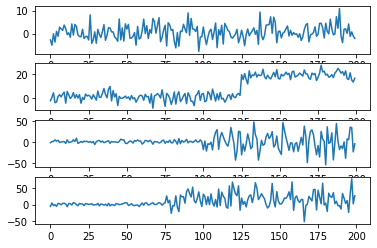

In [100]:
fig,ax = plt.subplots(zscore_dat_stack.shape[0], 1)
for this_dat, this_ax in zip(zscore_dat_stack, ax):
    this_ax.plot(this_dat)

### ==== Define Model ====

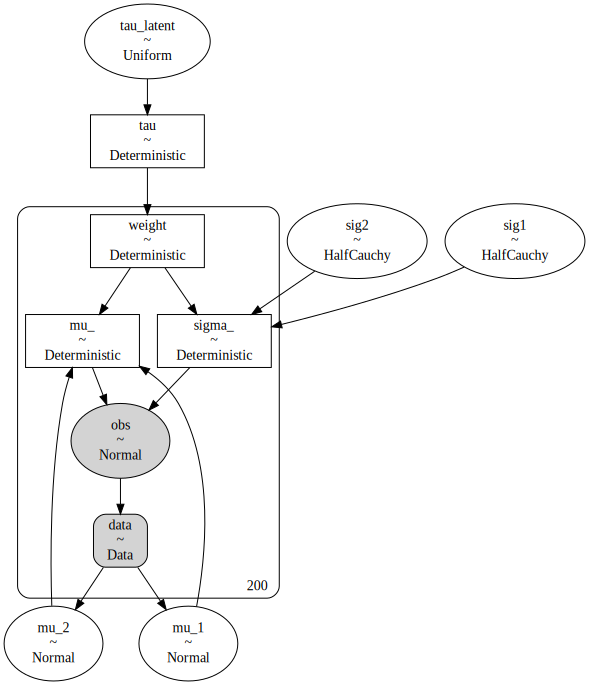

In [102]:
with pm.Model() as model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", zscore_dat_stack[0])
    # Defining variables with priors
    
    # Choosing to use sample mean to initialize prior on mu
    alpha = data.mean()
    
    # Before transition : mu_1, sigma1
    # After transition : mu_2, sigma2
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma1 = pm.HalfCauchy('sig1', 1)
    sigma2 = pm.HalfCauchy('sig2', 1)


    # Assume changepoint is between 0->1, we will scale accordingly
    # Uniform prior on position of changepoint
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    # Scale inferred changepoint so it is on scale of actual data
    idx = np.arange(len(zscore_dat_stack[0])) # Index
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better for sampler
    weight = pm.Deterministic('weight', tt.nnet.sigmoid(2 * (idx - tau)))
    mu_ = pm.Deterministic('mu_', (1 - weight) * mu_1 + weight * mu_2)
    sigma_ = pm.Deterministic('sigma_', (1 - weight) * sigma1 + weight * sigma2)

    # Using a normal likelihood (because data is normal)
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=data)

pm.model_to_graphviz(model)

In [103]:
trace_list = []
for this_data in zscore_dat_stack:
    with model:
            # Switch out the observed dataset
            pm.set_data({"data": this_data})
            test_trace = pm.sample(step = pm.NUTS())
            trace_list.append(test_trace)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig2, sig1, mu_2, mu_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig2, sig1, mu_2, mu_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig2, sig1, mu_2, mu_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig2, sig1, mu_2, mu_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


### ==== Plots ====

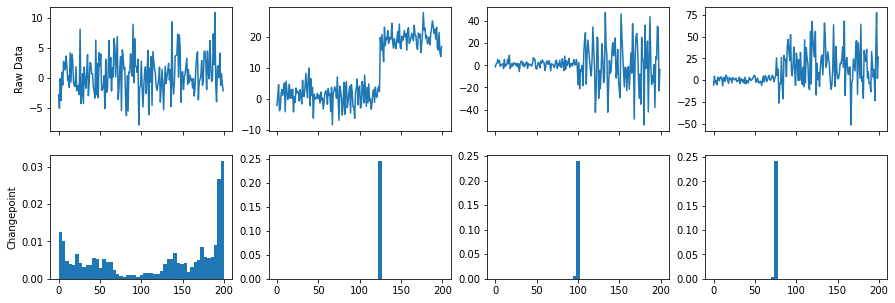

In [104]:
fig,ax = plt.subplots(2, zscore_dat_stack.shape[0], figsize = (15,5), sharex=True)
for num, this_dat in enumerate(zscore_dat_stack):
    ax[0,num].plot(this_dat)
    ax[1,num].hist(trace_list[num]['tau'], bins = np.linspace(0, length*2), density = True)
ax[0,0].set_ylabel('Raw Data');
ax[1,0].set_ylabel('Changepoint');

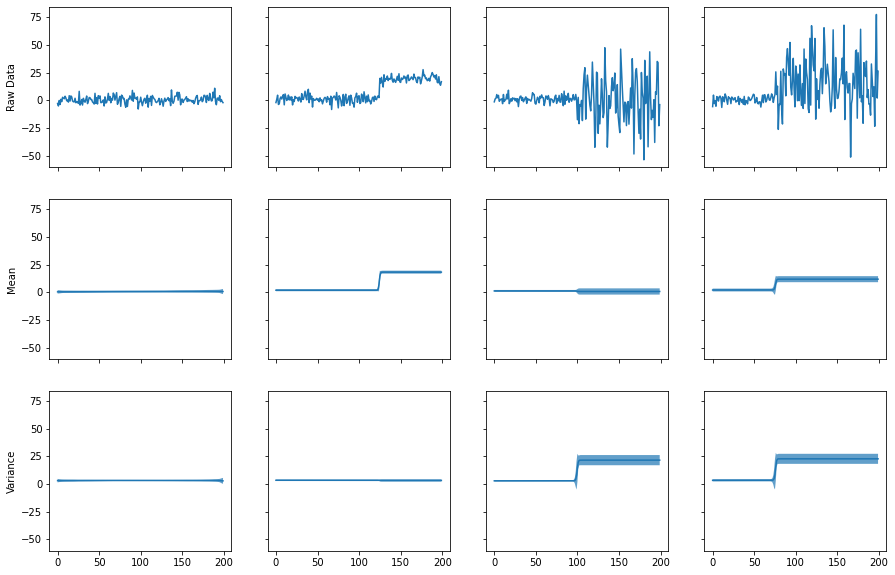

In [105]:
#plt.hist(test_trace['tau'],np.arange(0,2*length));
fig,ax = plt.subplots(3, zscore_dat_stack.shape[0], figsize = (15,10), sharex=True, sharey = True)
for num, this_dat in enumerate(zscore_dat_stack):
    ax[0,num].plot(this_dat)
    mean_mu = trace_list[num]['mu_'].mean(axis=0)
    std_mu = trace_list[num]['mu_'].std(axis=0)
    mean_sigma = trace_list[num]['sigma_'].mean(axis=0)
    std_sigma = trace_list[num]['sigma_'].std(axis=0)
    x = np.arange(len(mean_mu))
    ax[1,num].plot(x,mean_mu)
    ax[1,num].fill_between(x=x,
                           y1 = mean_mu + 3*std_mu,
                          y2 = mean_mu - 3*std_mu,
                          alpha = 0.7)
    ax[2,num].plot(trace_list[num]['sigma_'].mean(axis=0))
    ax[2,num].fill_between(x=x,
                           y1 = mean_sigma + 3*std_sigma,
                          y2 = mean_sigma - 3*std_sigma,
                          alpha = 0.7)
    
ax[0,0].set_ylabel('Raw Data');
ax[1,0].set_ylabel('Mean');
ax[2,0].set_ylabel('Variance');